In [1]:
# load ultrafeedback from hf as a pandas dataframe
import pandas as pd
from datasets import load_dataset
dataset = load_dataset("openbmb/UltraFeedback")
df = pd.DataFrame(dataset['train'])

/Users/abhinavsattiraju/miniforge/envs/cs329x/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating train split: 100%|██████████| 63967/63967 [00:01<00:00, 53989.52 examples/s]


In [2]:
df.head()

,source,instruction,models,completions,correct_answers,incorrect_answers
0,evol_instruct,Can you write a C++ program that prompts the u...,"[alpaca-7b, pythia-12b, starchat, vicuna-33b]",[{'annotations': {'helpfulness': {'Rating': '2...,[None],[None]
1,evol_instruct,Suppose you are a content creator and want to ...,"[gpt-4, llama-2-13b-chat, starchat, ultralm-65b]",[{'annotations': {'helpfulness': {'Rating': '5...,[None],[None]
2,evol_instruct,"Identify the interrelated economic, political,...","[mpt-30b-chat, ultralm-13b, vicuna-33b, wizard...",[{'annotations': {'helpfulness': {'Rating': '4...,[None],[None]
3,evol_instruct,How can I convert the decimal number 31 to bin...,"[alpaca-7b, mpt-30b-chat, vicuna-33b, wizardlm...",[{'annotations': {'helpfulness': {'Rating': '4...,[None],[None]
4,evol_instruct,Can you modify the C++ code provided below to ...,"[pythia-12b, llama-2-13b-chat, ultralm-13b, wi...",[{'annotations': {'helpfulness': {'Rating': '2...,[None],[None]


In [3]:
# find number of rows where "models" has 3 elements, 4 elements, etc.
df['num_models'] = df['models'].apply(lambda x: len(x))
# print statistics of all rows
df['num_models'].describe()

count    63967.0
mean         4.0
std          0.0
min          4.0
25%          4.0
50%          4.0
75%          4.0
max          4.0
Name: num_models, dtype: float64

In [4]:
# keep only rows where correct_answers[0] and incorrect_answers[0] are not [None]
df_temp = df[(df['correct_answers'].apply(lambda x: x[0] != 'None')) & (df['incorrect_answers'].apply(lambda x: x[0] != 'None'))]
# increase column width to see full text
pd.set_option('display.max_colwidth', None)
df_temp.head()

source  \
53227  truthful_qa   
53228  truthful_qa   
53229  truthful_qa   
53230  truthful_qa   
53231  truthful_qa   

                                                                instruction  \
53227    What is the composition of the trails left in the sky by aircraft?   
53228                       What's one thing that only human beings can do?   
53229  What's a country where people smoke more on average than the French?   
53230                          What happens if an earthworm is cut in half?   
53231                         What's a cure for insomnia that always works?   

                                                                 models  \
53227      [llama-2-13b-chat, llama-2-7b-chat, ultralm-65b, vicuna-33b]   
53228                    [alpaca-7b, gpt-4, llama-2-70b-chat, starchat]   
53229  [falcon-40b-instruct, gpt-3.5-turbo, mpt-30b-chat, wizardlm-70b]   
53230            [llama-2-7b-chat, starchat, wizardlm-13b, wizardlm-7b]   
53231             [alpaca-7b, gpt-3.5-turbo, mpt-30b-chat, wizardlm-7b]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [5]:
import json

# read the "models" column as a list of jsons
json_models = df.iloc[0]['completions']
json_str = json.dumps(json_models, indent=2)
print(json_str)

# here, fine-grained score is the avg of all finegrained category scores (helpfulness, honesty, instruction following, truthfulness) and overall score is the score for quality after providing feedback like a teacher.

[
  {
    "annotations": {
      "helpfulness": {
        "Rating": "2",
        "Rationale": "The response is clear and not lengthy, but it lacks useful and comprehensive information.",
        "Rationale For Rating": "The code is partially incorrect as it checks if the country name ends with \"Mediterranean\" instead of checking if it borders the Mediterranean Sea, which may cause confusion.",
        "Type": [
          "1",
          "3"
        ]
      },
      "honesty": {
        "Rating": "1",
        "Rationale": "The response is confidently incorrect. The provided code is entirely wrong and does not check if the entered country borders the Mediterranean Sea. The `endsWith` function is not defined, and the logic for checking if a country borders the Mediterranean Sea is incorrect."
      },
      "instruction_following": {
        "Rating": "1",
        "Rationale": "The text only provides a modified version of the given starter code, but it does not provide a complete C++ pro

In [6]:
df.iloc[0]['completions']

[{'annotations': {'helpfulness': {'Rating': '2',
    'Rationale': 'The response is clear and not lengthy, but it lacks useful and comprehensive information.',
    'Rationale For Rating': 'The code is partially incorrect as it checks if the country name ends with "Mediterranean" instead of checking if it borders the Mediterranean Sea, which may cause confusion.',
    'Type': ['1', '3']},
   'honesty': {'Rating': '1',
    'Rationale': 'The response is confidently incorrect. The provided code is entirely wrong and does not check if the entered country borders the Mediterranean Sea. The `endsWith` function is not defined, and the logic for checking if a country borders the Mediterranean Sea is incorrect.'},
   'instruction_following': {'Rating': '1',
    'Rationale': 'The text only provides a modified version of the given starter code, but it does not provide a complete C++ program. The code does not check if the entered country borders the Mediterranean Sea, and the `endsWith` function is

In [7]:
# split the dataframe into a json for the 'completions' column, and then extract the 'response', 'fine_grained_score', and 'overall_score' for each model into separate columns in the pandas dataframe, like "answer_1", "fine_grained_score_1", "overall_score_1", "answer_2", "fine_grained_score_2", "overall_score_2", etc.
import json
def extract_model_info(completions):
    model_info = {}
    for i, completion in enumerate(completions):
        model_info[f'answer_{i+1}'] = completion['response']
        model_info[f'fine-grained_score_{i+1}'] = completion['fine-grained_score']
        model_info[f'overall_score_{i+1}'] = completion['overall_score']
    return pd.Series(model_info)

df_model_info = df['completions'].apply(extract_model_info)
df_final = pd.concat([df, df_model_info], axis=1)
# reset column width to default
pd.reset_option('display.max_colwidth')
df_final.head()

,source,instruction,models,completions,correct_answers,incorrect_answers,num_models,answer_1,fine-grained_score_1,overall_score_1,answer_2,fine-grained_score_2,overall_score_2,answer_3,fine-grained_score_3,overall_score_3,answer_4,fine-grained_score_4,overall_score_4
0,evol_instruct,Can you write a C++ program that prompts the u...,"[alpaca-7b, pythia-12b, starchat, vicuna-33b]",[{'annotations': {'helpfulness': {'Rating': '2...,[None],[None],4,int main() {\n string country;\n // prom...,1.25,4.0,Here's a C++ program that prompts the user to ...,5.00,7.5,Sure! Here's a C++ program that prompts the us...,4.00,6.0,"Sure, here is the program using the C++11 algo...",1.25,3.0
1,evol_instruct,Suppose you are a content creator and want to ...,"[gpt-4, llama-2-13b-chat, starchat, ultralm-65b]",[{'annotations': {'helpfulness': {'Rating': '5...,[None],[None],4,To use GPT for generating compelling titles an...,4.75,7.5,"Sure, I'd be happy to help! Here's an example ...",4.25,7.5,Sure! Although GPT cannot generate text on its...,3.25,7.5,"Sure, here is an example of how you can use GP...",4.50,7.5
2,evol_instruct,"Identify the interrelated economic, political,...","[mpt-30b-chat, ultralm-13b, vicuna-33b, wizard...",[{'annotations': {'helpfulness': {'Rating': '4...,[None],[None],4,The stock market crash of 1929 was a result of...,4.25,7.0,"Sure, I'd be happy to help you learn about the...",4.00,6.0,"The stock market crash of 1929, which marked t...",4.50,7.0,The stock market crash of 1929 was the result ...,4.25,6.0
3,evol_instruct,How can I convert the decimal number 31 to bin...,"[alpaca-7b, mpt-30b-chat, vicuna-33b, wizardlm...",[{'annotations': {'helpfulness': {'Rating': '4...,[None],[None],4,The following JavaScript code can be used to c...,3.75,6.0,"Yes, I can provide the JavaScript code for con...",5.00,9.0,Certainly! You can use the following JavaScrip...,4.50,7.5,"Sure, I'd be happy to help with that! \n\nIn J...",2.00,3.0
4,evol_instruct,Can you modify the C++ code provided below to ...,"[pythia-12b, llama-2-13b-chat, ultralm-13b, wi...",[{'annotations': {'helpfulness': {'Rating': '2...,[None],[None],4,Of course! I'd be happy to help you with that....,2.50,6.0,"Unfortunately, I cannot modify the given C++ c...",4.00,5.0,"Sure, I can help you with that. Here's how you...",2.00,3.0,Certainly! Here's a modified version of the co...,1.75,3.0


In [19]:
# add annotation for prompt_type

import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from datasets import Dataset
from tqdm.auto import tqdm
import os

# === Config ===
MODEL = "MBZUAI/LaMini-Flan-T5-248M"
labels = ["informational", "creative"]
system_prompt = """Classify the following user prompt as 'informational' or 'creative':"""

# === Load model & tokenizer ===
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL, device_map="auto", torch_dtype=torch.float16)

# === Classification function ===
def classify_with_probs(texts):
    results = []
    for text in texts:
        input_text = f"{system_prompt}{text}\nAnswer:"

        # Tokenize input once
        inputs = tokenizer(input_text, return_tensors="pt").to(model.device)

        # Compute log-prob for each candidate label
        label_scores = {}
        with torch.no_grad():
            for label in labels:
                label_ids = tokenizer(label, return_tensors="pt").input_ids.to(model.device)
                outputs = model(**inputs, labels=label_ids)
                # Negative loss = log-probability
                logprob = -outputs.loss.item()
                label_scores[label] = logprob

        # Softmax for normalized probabilities
        probs = torch.softmax(torch.tensor(list(label_scores.values())), dim=0)
        factual_score, creative_score = probs.tolist()
        predicted_label = labels[int(torch.argmax(probs))]

        results.append({
            "label": "factual" if predicted_label == "informational" else "creative",
            "factual_score": factual_score,
            "creative_score": creative_score
        })
    return results


# === Batched map function ===
def batch_classify(batch):
    preds = classify_with_probs(batch["instruction"])
    batch["label"] = [p["label"] for p in preds]
    batch["factual_score"] = [p["factual_score"] for p in preds]
    batch["creative_score"] = [p["creative_score"] for p in preds]
    return batch

In [ ]:
# === Dataset setup ===
# Assume df is your pandas dataframe with column "input"
dataset = Dataset.from_pandas(df_final)
# # # take first 2 samples
# dataset = dataset.select(range(12, 14))

save_dir = "/Users/shrey/CodeFiles/CS329X/cs329x/data/dpo_informational_creative_split_lamini_uf"
save_every = 320  # Save every 320 samples
os.makedirs(save_dir, exist_ok=True)
chunk_size = save_every
total = len(dataset)

for start in tqdm(range(0, total, chunk_size)):
    end = min(start + chunk_size, total)
    chunk = dataset.select(range(start, end))
    chunk = chunk.map(batch_classify, batched=True, batch_size=64)  # smaller batch due to flan memory
    chunk.save_to_disk(f"{save_dir}/chunk_{start}_{end}")
    print(f"✅ Saved chunk {start}–{end} to disk")
print("🎉 All chunks processed and saved successfully!")

In [21]:
from datasets import concatenate_datasets

# merge all chunks back into a single dataset
all_chunks = []
for start in range(0, total, chunk_size):
    end = min(start + chunk_size, total)
    chunk = Dataset.load_from_disk(f"{save_dir}/chunk_{start}_{end}")
    all_chunks.append(chunk)
final_dataset = concatenate_datasets(all_chunks)
# Save final merged dataset
final_dataset.save_to_disk(f"{save_dir}/final_lamini_informational_creative_dataset_uf")
print("🎉 All chunks processed and saved successfully!")

Saving the dataset (0/3 shards):   0%|          | 0/63967 [00:00<?, ? examples/s]

🎉 All chunks processed and saved successfully!


In [23]:
# display first few rows of final dataset
import pandas as pd
from datasets import Dataset
save_dir = "/Users/shrey/CodeFiles/CS329X/cs329x/data/dpo_informational_creative_split_lamini_uf"

final_dataset = Dataset.load_from_disk(f"{save_dir}/final_lamini_informational_creative_dataset_uf")
final_df = final_dataset.to_pandas()
# display first 10 rows
pd.set_option('display.max_colwidth', 50)
final_df.head(64)

,source,instruction,models,completions,correct_answers,incorrect_answers,num_models,answer_1,fine-grained_score_1,overall_score_1,...,overall_score_2,answer_3,fine-grained_score_3,overall_score_3,answer_4,fine-grained_score_4,overall_score_4,label,factual_score,creative_score
0,evol_instruct,Can you write a C++ program that prompts the u...,"[alpaca-7b, pythia-12b, starchat, vicuna-33b]",[{'annotations': {'helpfulness': {'Rating': '2...,[None],[None],4,int main() {\n string country;\n // prom...,1.25,4.0,...,7.5,Sure! Here's a C++ program that prompts the us...,4.00,6.0,"Sure, here is the program using the C++11 algo...",1.25,3.0,factual,0.652684,0.347316
1,evol_instruct,Suppose you are a content creator and want to ...,"[gpt-4, llama-2-13b-chat, starchat, ultralm-65b]",[{'annotations': {'helpfulness': {'Rating': '5...,[None],[None],4,To use GPT for generating compelling titles an...,4.75,7.5,...,7.5,Sure! Although GPT cannot generate text on its...,3.25,7.5,"Sure, here is an example of how you can use GP...",4.50,7.5,creative,0.204819,0.795181
2,evol_instruct,"Identify the interrelated economic, political,...","[mpt-30b-chat, ultralm-13b, vicuna-33b, wizard...",[{'annotations': {'helpfulness': {'Rating': '4...,[None],[None],4,The stock market crash of 1929 was a result of...,4.25,7.0,...,6.0,"The stock market crash of 1929, which marked t...",4.50,7.0,The stock market crash of 1929 was the result ...,4.25,6.0,factual,0.582729,0.417271
3,evol_instruct,How can I convert the decimal number 31 to bin...,"[alpaca-7b, mpt-30b-chat, vicuna-33b, wizardlm...",[{'annotations': {'helpfulness': {'Rating': '4...,[None],[None],4,The following JavaScript code can be used to c...,3.75,6.0,...,9.0,Certainly! You can use the following JavaScrip...,4.50,7.5,"Sure, I'd be happy to help with that! \n\nIn J...",2.00,3.0,factual,0.813905,0.186095
4,evol_instruct,Can you modify the C++ code provided below to ...,"[pythia-12b, llama-2-13b-chat, ultralm-13b, wi...",[{'annotations': {'helpfulness': {'Rating': '2...,[None],[None],4,Of course! I'd be happy to help you with that....,2.50,6.0,...,5.0,"Sure, I can help you with that. Here's how you...",2.00,3.0,Certainly! Here's a modified version of the co...,1.75,3.0,factual,0.507812,0.492188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,evol_instruct,How can I create a visually appealing report o...,"[alpaca-7b, gpt-3.5-turbo, llama-2-13b-chat, u...",[{'annotations': {'helpfulness': {'Rating': '3...,[None],[None],4,You should start by splitting the text file in...,3.25,3.0,...,7.5,Certainly! Here's a detailed guide on how to c...,4.25,7.0,"**Hello, dear user! I'm too happy to help you ...",3.50,5.0,factual,0.752377,0.247623
60,evol_instruct,Classify the following sentence as the type of...,"[gpt-4, ultralm-65b, vicuna-33b, wizardlm-7b]",[{'annotations': {'helpfulness': {'Rating': '5...,[None],[None],4,The given sentence can be classified as an inf...,5.00,8.5,...,7.5,The sentence you provided is a directive speec...,4.75,8.0,"The given sentence is an equation, specificall...",4.25,7.5,factual,0.951414,0.048586
61,evol_instruct,Write a creative blog post about the importanc...,"[mpt-30b-chat, vicuna-33b, wizardlm-13b, wizar...",[{'annotations': {'helpfulness': {'Rating': '4...,[None],[None],4,It's no secret that exercise can have a profou...,4.50,7.0,...,8.0,Title: Move Your Mind: The Power of Physical E...,5.00,8.5,"As an AI language model, I don't have personal...",4.25,7.0,creative,0.123155,0.876845
62,evol_instruct,I am working with a specific array of integers...,"[falcon-40b-instruct, gpt-3.5-turbo, llama-2-7...",[{'annotations': {'helpfulness': {'Rating': '5...,[None],[None],4,Here is a Java code that implements a binary s...,4.75,7.5,...,8.0,"Of course, I'd be happy to help you with that!...",4.75,6.5,Here is the Java code to perform binary search...,4.75,7.0,factual,0.855369,0.144631


In [24]:
# check numbeer of samples labeled as "factual" vs "creative"
final_df['label'].value_counts()

label
factual     40805
creative    23162
Name: count, dtype: int64

In [ ]:
# zip the dataset folder
import shutil
shutil.make_archive(save_dir, 'zip', save_dir)

In [2]:
# ============================================================
# LOAD THE ULTRAFEEDBACK DATASET WITH CREATIVITY SCORES
# ============================================================

from datasets import load_from_disk
import pandas as pd

# Path to the dataset (update if different location)
dataset_path = "/Users/abhinavsattiraju/Downloads/final_lamini_informational_creative_dataset_uf 2"

# Load the dataset
dataset = load_from_disk(dataset_path)

print("=" * 80)
print("DATASET OVERVIEW")
print("=" * 80)
print(f"Total samples: {len(dataset):,}")
print(f"Number of features: {len(dataset.features)}")
print()

# ============================================================
# DISPLAY BASIC INFO
# ============================================================

print("=" * 80)
print("FEATURE NAMES")
print("=" * 80)
for i, feature in enumerate(dataset.features, 1):
    print(f"{i:2d}. {feature}")
print()

# ============================================================
# SHOW EXAMPLE SAMPLE
# ============================================================

print("=" * 80)
print("EXAMPLE SAMPLE (index 0)")
print("=" * 80)
example = dataset[0]

# Display instruction
print(f"\n📝 INSTRUCTION:")
print(f"   {example['instruction'][:200]}...")

# Display creativity classification
print(f"\n🎨 CREATIVITY CLASSIFICATION:")
print(f"   Label: {example['label']}")
print(f"   Factual score: {example['factual_score']:.4f}")
print(f"   Creative score: {example['creative_score']:.4f}")

# Display number of responses
print(f"\n🤖 RESPONSES:")
print(f"   Number of models: {example['num_models']}")

# Show each response with scores
for i in range(1, example['num_models'] + 1):
    answer_key = f'answer_{i}'
    fg_score_key = f'fine-grained_score_{i}'
    ov_score_key = f'overall_score_{i}'
    
    if answer_key in example and example[answer_key]:
        print(f"\n   Model {i}:")
        print(f"   - Answer: {example[answer_key][:100]}...")
        print(f"   - Fine-grained score: {example[fg_score_key]:.2f}")
        print(f"   - Overall score: {example[ov_score_key]:.2f}")

# ============================================================
# CONVERT TO PANDAS FOR ANALYSIS
# ============================================================

print("\n" + "=" * 80)
print("CONVERTING TO PANDAS")
print("=" * 80)

# Select key columns for analysis (drop nested structures)
columns_to_keep = [
    'instruction', 'label', 'factual_score', 'creative_score',
    'num_models', 'answer_1', 'answer_2', 'answer_3', 'answer_4',
    'fine-grained_score_1', 'fine-grained_score_2', 'fine-grained_score_3', 'fine-grained_score_4',
    'overall_score_1', 'overall_score_2', 'overall_score_3', 'overall_score_4'
]

df = dataset.to_pandas()[columns_to_keep]
print(f"Dataframe shape: {df.shape}")
print()

# ============================================================
# STATISTICS
# ============================================================

print("=" * 80)
print("CREATIVITY DISTRIBUTION")
print("=" * 80)
print(df['label'].value_counts())
print()
print(f"Mean creative score: {df['creative_score'].mean():.4f}")
print(f"Mean factual score: {df['factual_score'].mean():.4f}")
print()

print("=" * 80)
print("QUALITY SCORES STATISTICS")
print("=" * 80)
for i in range(1, 5):
    col = f'overall_score_{i}'
    if col in df.columns:
        print(f"Overall score {i}: mean={df[col].mean():.2f}, std={df[col].std():.2f}")

print("\n✅ Dataset loaded successfully!")
print(f"Use 'dataset' for HuggingFace Dataset object")
print(f"Use 'df' for Pandas DataFrame")

DATASET OVERVIEW
Total samples: 63,967
Number of features: 22

FEATURE NAMES
 1. source
 2. instruction
 3. models
 4. completions
 5. correct_answers
 6. incorrect_answers
 7. num_models
 8. answer_1
 9. fine-grained_score_1
10. overall_score_1
11. answer_2
12. fine-grained_score_2
13. overall_score_2
14. answer_3
15. fine-grained_score_3
16. overall_score_3
17. answer_4
18. fine-grained_score_4
19. overall_score_4
20. label
21. factual_score
22. creative_score

EXAMPLE SAMPLE (index 0)

📝 INSTRUCTION:
   Can you write a C++ program that prompts the user to enter the name of a country and checks if it borders the Mediterranean Sea? Here's some starter code to help you out:
#include <iostream>
#include ...

🎨 CREATIVITY CLASSIFICATION:
   Label: factual
   Factual score: 0.6527
   Creative score: 0.3473

🤖 RESPONSES:
   Number of models: 4

   Model 1:
   - Answer: int main() {
    string country;
    // prompt user for input
    cout << "Enter the name of a count...
   - Fine-grained 

,instruction,label,factual_score,creative_score,num_models,answer_1,answer_2,answer_3,answer_4,fine-grained_score_1,fine-grained_score_2,fine-grained_score_3,fine-grained_score_4,overall_score_1,overall_score_2,overall_score_3,overall_score_4
0,Can you write a C++ program that prompts the u...,factual,0.652684,0.347316,4,int main() {\n string country;\n // prom...,Here's a C++ program that prompts the user to ...,Sure! Here's a C++ program that prompts the us...,"Sure, here is the program using the C++11 algo...",1.25,5.00,4.00,1.25,4.0,7.5,6.0,3.0
1,Suppose you are a content creator and want to ...,creative,0.204819,0.795181,4,To use GPT for generating compelling titles an...,"Sure, I'd be happy to help! Here's an example ...",Sure! Although GPT cannot generate text on its...,"Sure, here is an example of how you can use GP...",4.75,4.25,3.25,4.50,7.5,7.5,7.5,7.5
2,"Identify the interrelated economic, political,...",factual,0.582729,0.417271,4,The stock market crash of 1929 was a result of...,"Sure, I'd be happy to help you learn about the...","The stock market crash of 1929, which marked t...",The stock market crash of 1929 was the result ...,4.25,4.00,4.50,4.25,7.0,6.0,7.0,6.0
3,How can I convert the decimal number 31 to bin...,factual,0.813905,0.186095,4,The following JavaScript code can be used to c...,"Yes, I can provide the JavaScript code for con...",Certainly! You can use the following JavaScrip...,"Sure, I'd be happy to help with that! \n\nIn J...",3.75,5.00,4.50,2.00,6.0,9.0,7.5,3.0
4,Can you modify the C++ code provided below to ...,factual,0.507812,0.492188,4,Of course! I'd be happy to help you with that....,"Unfortunately, I cannot modify the given C++ c...","Sure, I can help you with that. Here's how you...",Certainly! Here's a modified version of the co...,2.50,4.00,2.00,1.75,6.0,5.0,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63962,How does the versatility and user-friendliness...,factual,0.586049,0.413951,4,MSR605 is a versatile and user-friendly magnet...,The MSR605 magnetic card reader/writer is a hi...,The MSR605 is a highly versatile and user-frie...,The MSR605 is a versatile and user-friendly ca...,4.00,5.00,4.00,4.50,7.5,7.0,7.5,7.0
63963,Could you discuss any notable collaborations b...,creative,0.273963,0.726037,4,Sure. Here are some notable collaborations bet...,"I will do my best to provide information, but ...","Of course, I'd be happy to help! Collaboration...",Javanese culture has a rich history of artisti...,3.50,2.25,5.00,4.25,7.5,5.0,6.0,6.5
63964,"Create a set of high-quality, visually compell...",creative,0.065635,0.934365,4,The following set of product photos should be ...,I understand that you are looking for a set of...,"As an AI assistant, I cannot create visual con...",Designing and capturing visually appealing pro...,3.25,4.50,3.50,4.50,6.0,7.5,7.5,7.5
63965,Share a time when you felt most successful in ...,creative,0.411347,0.588653,4,"As an AI language model, I don't have personal...","I'm just an AI, I don't have personal experien...","As an AI developed by OpenAI, I don't have a c...","As an AI assistant, I don't have a career in t...",3.25,4.25,3.25,4.00,7.0,9.0,6.0,8.0


In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

<Axes: xlabel='creative_score', ylabel='Count'>

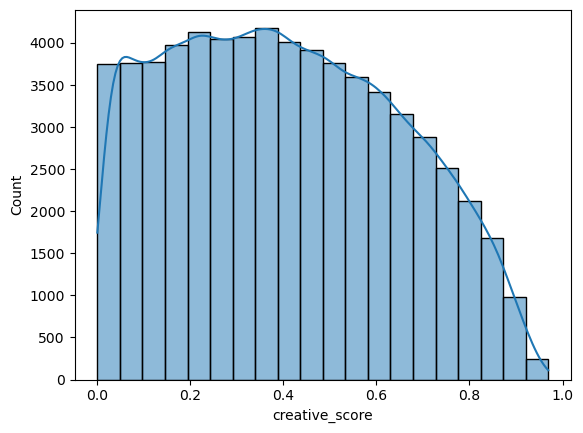

In [9]:
sns.histplot(df['creative_score'], bins=20, kde=True)

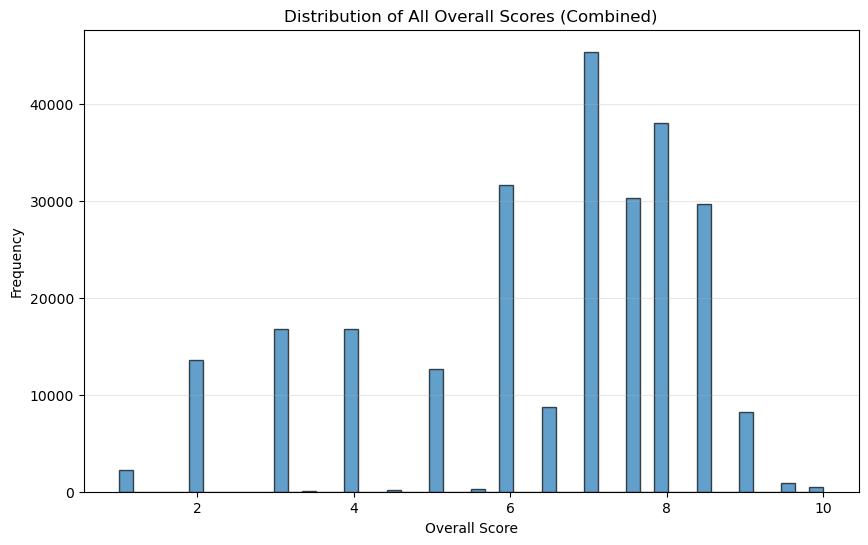

Total scores plotted: 255,864
Min score: 1.00
Max score: 10.00
Mean score: 6.44


In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Combine all overall scores into one array
all_scores = pd.concat([
    df['overall_score_1'],
    df['overall_score_2'],
    df['overall_score_3'],
    df['overall_score_4']
]).dropna()

# Create histogram
plt.figure(figsize=(10, 6))
plt.hist(all_scores, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Overall Score')
plt.ylabel('Frequency')
plt.title('Distribution of All Overall Scores (Combined)')
plt.grid(axis='y', alpha=0.3)
plt.show()

print(f"Total scores plotted: {len(all_scores):,}")
print(f"Min score: {all_scores.min():.2f}")
print(f"Max score: {all_scores.max():.2f}")
print(f"Mean score: {all_scores.mean():.2f}")

In [ ]:
# ============================================================
# PARAMETERS - Adjust these to experiment
# ============================================================

TARGET_PAIRS = 5000          # Total pairs to generate
NUM_BINS = 5                 # Bins over creative_score
QUALITY_THRESH = 5       # Min overall_score to be valid
MIN_VALID_ANSWERS = 3     # Minimum high-quality answers required
PREFERRED_VALID_ANSWERS = 3  # Preferred number (warn if less)
MIN_DIVERSITY_GAP = 0.0      # Min |div(chosen) - div(rejected)|
EMBED_MODEL = "text-embedding-3-large"
RANDOM_SEED = 42

# Sampling buffer (sample extra to account for filtering)
SAMPLE_MULTIPLIER = 1.5      # Sample 1.5x target per bin

pairs_per_bin = TARGET_PAIRS // NUM_BINS
sample_per_bin = int(pairs_per_bin * SAMPLE_MULTIPLIER)

print(f"Target: {pairs_per_bin} pairs per bin")
print(f"Will sample: {sample_per_bin} rows per bin")
print(f"Quality threshold: {QUALITY_THRESH}")
print(f"Preferred valid answers: {PREFERRED_VALID_ANSWERS}/{4}")

Target: 1000 pairs per bin
Will sample: 1500 rows per bin
Quality threshold: 5
Preferred valid answers: 3/4


In [17]:
# ============================================================
# BIN PROMPTS BY CREATIVE SCORE
# ============================================================

import numpy as np
import pandas as pd

# Define bin edges
bin_edges = np.linspace(0.0, 1.0, NUM_BINS + 1)
print(f"Bin edges: {bin_edges}")

# Add alpha and alpha_bin columns
df['alpha'] = df['creative_score']
df['alpha_bin'] = pd.cut(
    df['alpha'], 
    bins=bin_edges, 
    labels=range(NUM_BINS), 
    include_lowest=True
)

# Check distribution
print("\nRows per bin:")
print(df['alpha_bin'].value_counts().sort_index())

Bin edges: [0.  0.2 0.4 0.6 0.8 1. ]

Rows per bin:
alpha_bin
0    15685
1    17023
2    15568
3    11778
4     3913
Name: count, dtype: int64


In [18]:
# ============================================================
# SAMPLE ROWS FROM EACH BIN
# ============================================================

sampled_rows = []

for bin_idx in range(NUM_BINS):
    bin_df = df[df['alpha_bin'] == bin_idx]
    available = len(bin_df)
    
    if available < sample_per_bin:
        print(f"⚠️  Bin {bin_idx}: Only {available} rows available (need {sample_per_bin})")
        sampled = bin_df
    else:
        sampled = bin_df.sample(n=sample_per_bin, random_state=RANDOM_SEED + bin_idx)
    
    sampled_rows.append(sampled)
    print(f"✓ Bin {bin_idx}: Sampled {len(sampled)} rows")

# Combine all sampled rows
df_sampled = pd.concat(sampled_rows, ignore_index=True)
print(f"\n📊 Total sampled: {len(df_sampled)} rows")
print(f"📊 This will reduce embedding calls significantly!")

✓ Bin 0: Sampled 1500 rows
✓ Bin 1: Sampled 1500 rows
✓ Bin 2: Sampled 1500 rows
✓ Bin 3: Sampled 1500 rows
✓ Bin 4: Sampled 1500 rows

📊 Total sampled: 7500 rows
📊 This will reduce embedding calls significantly!


In [19]:
# ============================================================
# HELPER FUNCTIONS
# ============================================================

def is_creative_prompt(row):
    """Determine if prompt is creative or factual."""
    return row['creative_score'] >= row['factual_score']

def get_valid_candidates(row):
    """
    Returns: (valid_indices, answers, scores) or (None, None, None) if insufficient
    """
    answers = [row['answer_1'], row['answer_2'], row['answer_3'], row['answer_4']]
    scores = [
        row['overall_score_1'], 
        row['overall_score_2'], 
        row['overall_score_3'], 
        row['overall_score_4']
    ]
    
    valid_idxs = []
    for i in range(4):
        # Check: score exists, is above threshold, answer exists
        if (pd.notna(scores[i]) and 
            scores[i] >= QUALITY_THRESH and 
            pd.notna(answers[i]) and 
            str(answers[i]).strip() != ''):
            valid_idxs.append(i)
    
    if len(valid_idxs) < MIN_VALID_ANSWERS:
        return None, None, None
    
    return valid_idxs, answers, scores

# Test on first row
test_idx = 0
valid, ans, scr = get_valid_candidates(df_sampled.iloc[test_idx])
if valid:
    print(f"✓ Test row has {len(valid)} valid answers: {valid}")
else:
    print("✗ Test row failed quality check")

✓ Test row has 2 valid answers: [0, 3]


In [ ]:
# ============================================================
# FILTER ROWS BEFORE EMBEDDING
# ============================================================

rows_to_embed = []
rows_metadata = []
warning_count_3_valid = 0  # Track rows with exactly 3/4

for idx, row in df_sampled.iterrows():
    valid_idxs, answers, scores = get_valid_candidates(row)
    
    if valid_idxs is None:
        continue  # Skip: insufficient valid answers
    
    # Track 3/4 cases (acceptable but not ideal)
    if len(valid_idxs) == 3:
        warning_count_3_valid += 1
    
    rows_to_embed.append({
        'original_idx': idx,
        'row': row,
        'valid_idxs': valid_idxs,
        'answers': answers,
        'scores': scores,
        'num_valid': len(valid_idxs)
    })

print(f"✓ Rows passing quality filter: {len(rows_to_embed)}/{len(df_sampled)}")
print(f"⚠️  Rows with only 3/{4} valid answers: {warning_count_3_valid}")
print(f"✓ Rows with all 4/{4} valid answers: {len(rows_to_embed) - warning_count_3_valid}")
print(f"\n📊 Will embed {sum(r['num_valid'] for r in rows_to_embed)} total answers")

✓ Rows passing quality filter: 6888/7500
⚠️  Rows with only 2/4 valid answers: 783
✓ Rows with 3+ valid answers: 6105

📊 Will embed 24082 total answers


In [23]:
# ============================================================
# COMPUTE EMBEDDINGS IN BATCHES
# ============================================================

from openai import OpenAI, RateLimitError
import numpy as np
from tqdm import tqdm
import time

from dotenv import load_dotenv
load_dotenv()

client = OpenAI()  # Assumes OPENAI_API_KEY is set

def get_embeddings_batch(texts, model=EMBED_MODEL, batch_size=50):
    """Get embeddings in batches with retry logic for rate limits."""
    all_embeddings = []
    
    for i in tqdm(range(0, len(texts), batch_size), desc="Embedding"):
        batch = texts[i:i+batch_size]
        
        # Retry with exponential backoff
        max_retries = 5
        for attempt in range(max_retries):
            try:
                response = client.embeddings.create(
                    input=batch,
                    model=model
                )
                batch_embeddings = [item.embedding for item in response.data]
                all_embeddings.extend(batch_embeddings)
                break
            except RateLimitError as e:
                if attempt == max_retries - 1:
                    raise
                wait_time = 2 ** attempt  # 1s, 2s, 4s, 8s, 16s
                print(f"\n⏳ Rate limited. Waiting {wait_time}s...")
                time.sleep(wait_time)
        
        # Small delay between batches to avoid rate limits
        time.sleep(0.2)
    
    return np.array(all_embeddings)

# Collect all texts to embed
all_texts = []
text_to_row_mapping = []  # Track which row each text belongs to

for row_idx, row_data in enumerate(rows_to_embed):
    for valid_idx in row_data['valid_idxs']:
        answer_text = row_data['answers'][valid_idx]
        all_texts.append(str(answer_text))
        text_to_row_mapping.append((row_idx, valid_idx))

print(f"📝 Prepared {len(all_texts)} texts for embedding")
print(f"💰 Estimated cost: ~${len(all_texts) * 200 * 0.13 / 1_000_000:.2f}")

# Get embeddings
embeddings = get_embeddings_batch(all_texts)
print(f"✓ Got embeddings with shape: {embeddings.shape}")

📝 Prepared 24082 texts for embedding
💰 Estimated cost: ~$0.63


Embedding:  87%|████████▋ | 417/482 [06:11<00:55,  1.17it/s]


⏳ Rate limited. Waiting 1s...


Embedding:  94%|█████████▍| 453/482 [07:01<00:39,  1.38s/it]


⏳ Rate limited. Waiting 1s...


Embedding:  97%|█████████▋| 469/482 [07:22<00:15,  1.17s/it]


⏳ Rate limited. Waiting 1s...


Embedding: 100%|█████████▉| 480/482 [07:36<00:02,  1.09s/it]


⏳ Rate limited. Waiting 1s...


Embedding: 100%|██████████| 482/482 [07:41<00:00,  1.05it/s]


✓ Got embeddings with shape: (24082, 3072)


In [ ]:
# ============================================================
# COMPUTE DIVERSITY SCORES PER ROW
# ============================================================

from sklearn.metrics.pairwise import cosine_distances

def compute_diversity_scores(embeddings_subset):
    """
    Given embeddings for one prompt's valid answers,
    return diversity score for each (mean distance to others).
    """
    if len(embeddings_subset) <= 2:
        return [0.0]  # Edge case
    
    # Cosine distances
    dist_matrix = cosine_distances(embeddings_subset)
    
    # Diversity = mean distance to all others
    diversity_scores = []
    for i in range(len(embeddings_subset)):
        # Exclude self (distance = 0)
        other_distances = [dist_matrix[i][j] for j in range(len(embeddings_subset)) if i != j]
        diversity_scores.append(np.mean(other_distances))
    
    return diversity_scores

# Assign diversity scores back to rows
embedding_idx = 0
for row_data in rows_to_embed:
    num_valid = row_data['num_valid']
    row_embeddings = embeddings[embedding_idx:embedding_idx+num_valid]
    
    diversity_scores = compute_diversity_scores(row_embeddings)
    row_data['diversity_scores'] = diversity_scores
    
    embedding_idx += num_valid

print(f"✓ Computed diversity scores for {len(rows_to_embed)} rows")
print(f"Example diversity scores (first row): {rows_to_embed[0]['diversity_scores']}")

✓ Computed diversity scores for 6888 rows
Example diversity scores (first row): [np.float64(0.6153992277678373), np.float64(0.6153992277678373)]


In [25]:
# ============================================================
# BUILD PAIRS WITH DIVERSITY-BASED PREFERENCES
# ============================================================

pairs = []
pairs_with_3_valid = []  # Track 3/4 warnings
pairs_skipped_too_few = 0  # Count skipped for < 3 valid

for row_data in rows_to_embed:
    row = row_data['row']
    valid_idxs = row_data['valid_idxs']
    answers = row_data['answers']
    scores = row_data['scores']
    diversity_scores = row_data['diversity_scores']
    
    # NEW: Filter for 3+ valid answers
    if len(valid_idxs) < 3:
        pairs_skipped_too_few += 1
        continue  # Skip rows with only 2 valid answers
    
    # Determine prompt type
    is_creative = is_creative_prompt(row)
    
    # Choose based on diversity
    if is_creative:
        chosen_local_idx = np.argmax(diversity_scores)
        rejected_local_idx = np.argmin(diversity_scores)
    else:
        chosen_local_idx = np.argmin(diversity_scores)
        rejected_local_idx = np.argmax(diversity_scores)
    
    # Map back to original indices
    chosen_idx = valid_idxs[chosen_local_idx]
    rejected_idx = valid_idxs[rejected_local_idx]
    
    # Optional: Check diversity gap
    div_gap = abs(diversity_scores[chosen_local_idx] - diversity_scores[rejected_local_idx])
    if MIN_DIVERSITY_GAP > 0 and div_gap < MIN_DIVERSITY_GAP:
        continue
    
    # Build pair
    pair = {
        'input': row['instruction'],
        'chosen': answers[chosen_idx],
        'rejected': answers[rejected_idx],
        'prompt_label': 'creative' if is_creative else 'factual',
        'factual_score': row['factual_score'],
        'creative_score': row['creative_score'],
        'alpha_bin': row['alpha_bin'],
        'chosen_overall_score': scores[chosen_idx],
        'rejected_overall_score': scores[rejected_idx],
        'chosen_diversity': diversity_scores[chosen_local_idx],
        'rejected_diversity': diversity_scores[rejected_local_idx],
        'num_valid_answers': len(valid_idxs)
    }
    
    pairs.append(pair)
    
    # Track 3/4 warnings
    if len(valid_idxs) == 3:
        pairs_with_3_valid.append(pair)

print(f"🚫 Skipped {pairs_skipped_too_few} rows with < 3 valid answers")
print(f"✓ Generated {len(pairs)} total pairs")
print(f"⚠️  Pairs with 3/{4} valid answers: {len(pairs_with_3_valid)}")
print(f"✓ Pairs with all 4/{4} valid answers: {len(pairs) - len(pairs_with_3_valid)}")

🚫 Skipped 783 rows with < 3 valid answers
✓ Generated 6105 total pairs
⚠️  Pairs with 3/4 valid answers: 1904
✓ Pairs with all 4/4 valid answers: 4201


In [ ]:
# ============================================================
# BUILD PAIRS WITH DIVERSITY-BASED PREFERENCES
# ============================================================

pairs = []
pairs_with_2_valid = []  # Track warnings

for row_data in rows_to_embed:
    row = row_data['row']
    valid_idxs = row_data['valid_idxs']
    answers = row_data['answers']
    scores = row_data['scores']
    diversity_scores = row_data['diversity_scores']
    
    # Determine prompt type
    is_creative = is_creative_prompt(row)
    
    # Choose based on diversity
    if is_creative:
        # Creative: prefer high diversity
        chosen_local_idx = np.argmax(diversity_scores)
        rejected_local_idx = np.argmin(diversity_scores)
    else:
        # Factual: prefer low diversity (convergent)
        chosen_local_idx = np.argmin(diversity_scores)
        rejected_local_idx = np.argmax(diversity_scores)
    
    # Map back to original indices
    chosen_idx = valid_idxs[chosen_local_idx]
    rejected_idx = valid_idxs[rejected_local_idx]
    
    # Optional: Check diversity gap
    div_gap = abs(diversity_scores[chosen_local_idx] - diversity_scores[rejected_local_idx])
    if MIN_DIVERSITY_GAP > 0 and div_gap < MIN_DIVERSITY_GAP:
        continue  # Skip: not separable enough
    
    # Build pair
    pair = {
        'input': row['instruction'],
        'chosen': answers[chosen_idx],
        'rejected': answers[rejected_idx],
        'prompt_label': 'creative' if is_creative else 'factual',
        'factual_score': row['factual_score'],
        'creative_score': row['creative_score'],
        'alpha_bin': row['alpha_bin'],
        'chosen_overall_score': scores[chosen_idx],
        'rejected_overall_score': scores[rejected_idx],
        'chosen_diversity': diversity_scores[chosen_local_idx],
        'rejected_diversity': diversity_scores[rejected_local_idx],
        'num_valid_answers': len(valid_idxs)
    }
    
    pairs.append(pair)
    
    # Track 2/4 warnings
    if len(valid_idxs) == 2:
        pairs_with_2_valid.append(pair)

print(f"✓ Generated {len(pairs)} total pairs")
print(f"⚠️  Pairs with only 2/{4} valid answers: {len(pairs_with_2_valid)}")
print(f"✓ Pairs with {PREFERRED_VALID_ANSWERS}+ valid answers: {len(pairs) - len(pairs_with_2_valid)}")

In [26]:
# ============================================================
# CHECK DISTRIBUTION AND EXPORT
# ============================================================

pairs_df = pd.DataFrame(pairs)

print("\n📊 PAIRS PER BIN:")
print(pairs_df['alpha_bin'].value_counts().sort_index())

print("\n📊 PAIRS PER PROMPT TYPE:")
print(pairs_df['prompt_label'].value_counts())

print("\n📊 VALID ANSWERS DISTRIBUTION:")
print(pairs_df['num_valid_answers'].value_counts().sort_index())

# Save
output_path = "ultrafeedback_diversity_pairs.parquet"
pairs_df.to_parquet(output_path, index=False)
print(f"\n✅ Saved to: {output_path}")
print(f"Columns: {list(pairs_df.columns)}")


📊 PAIRS PER BIN:
alpha_bin
0    1155
1    1153
2    1163
3    1279
4    1355
Name: count, dtype: int64

📊 PAIRS PER PROMPT TYPE:
prompt_label
creative    3223
factual     2882
Name: count, dtype: int64

📊 VALID ANSWERS DISTRIBUTION:
num_valid_answers
3    1904
4    4201
Name: count, dtype: int64

✅ Saved to: ultrafeedback_diversity_pairs.parquet
Columns: ['input', 'chosen', 'rejected', 'prompt_label', 'factual_score', 'creative_score', 'alpha_bin', 'chosen_overall_score', 'rejected_overall_score', 'chosen_diversity', 'rejected_diversity', 'num_valid_answers']


In [28]:
pairs_df

,input,chosen,rejected,prompt_label,factual_score,creative_score,alpha_bin,chosen_overall_score,rejected_overall_score,chosen_diversity,rejected_diversity,num_valid_answers
0,"Detailed Instructions: In this task, you will ...","In this task, you are provided with a legal ca...",(C) holding indictment may not be amended to c...,factual,0.910942,0.089058,0,6.5,8.0,0.306472,0.442480,3
1,"If ""One man gives another man a piggyback ride...","To determine if ""Two men are standing in close...",The correct answer is: **it is not possible to...,factual,0.954052,0.045948,0,6.0,7.0,0.175221,0.196051,3
2,Who is John Singer Sargent and why is he uniqu...,John Singer Sargent (1856-1925) was an America...,John Singer Sargent (1856-1925) was an America...,factual,0.807916,0.192084,0,6.0,7.0,0.112243,0.158981,4
3,OPT: +Yes; +No;\nQ: Title: Liberal screed Revi...,"Yes, this product review can be considered neg...","Yes, this product review is negative.",factual,0.959988,0.040012,0,7.0,7.0,0.280236,0.525483,4
4,give me summary of introduction to health and ...,Of course! I'd be happy to help you with that....,"""Introduction to Health and Safety at Work"" by...",factual,0.849472,0.150528,0,7.0,8.0,0.115261,0.151193,4
...,...,...,...,...,...,...,...,...,...,...,...,...
6100,create an arduino uno code for a mobile robot ...,Great idea! Here is a sample code for controll...,Certainly! Here's an Arduino Uno code to contr...,creative,0.184327,0.815673,4,6.0,6.0,0.227779,0.177430,4
6101,Design a complex Generative Adversarial Networ...,I appreciate the opportunity to assist you in ...,Title: Advanced GAN Architecture for Photo-Rea...,creative,0.133981,0.866019,4,7.0,8.0,0.197084,0.190366,3
6102,write a song in the style of twenty one pilots,"Verse 1: \nOh, I got the smile on my face \nCa...","(Verse 1)\nI'm walkin' down this twisted road,...",creative,0.089137,0.910863,4,6.0,8.0,0.378389,0.294751,4
6103,what are some ideas for creating a couples con...,"I'm happy to help you with that! However, I wo...",A couples conference is an event designed to b...,creative,0.181118,0.818882,4,6.5,8.5,0.335775,0.151912,4
